In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pyteomics import mgf
from spectrum_utils import plot
from spectrum_utils import spectrum

In [2]:
# Use LaTeX to format pretty plot titles. (This is generally not necessary.)
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

# `spectrum_utils` quickstart

## Spectrum preprocessing

`spectrum_utils` provides general MS/MS **preprocessing** features. As an example we will process the spectrum as follows:

- Restrict the mass range to [100, 1400] m/z to filter out irrelevant peaks.
- Remove the unfragmented precursor peak.
- Remove low-intensity noise peaks by only retaining peaks that are at least 5% as intense as the base peak and potentially further restricting the total number of peaks in the spectrum.
- Scale the peak intensities by their square root to de-emphasize overly intense peaks. (Alternative scaling methods are log scaling and rank scaling.)
- Annotate peaks corresponding to 'b', 'y', and 'a' peptide fragments.

`spectrum_utils` contains simple **plotting** functions to plot a single MS/MS spectrum individually or mirror plot two MS/MS spectra to visualize their correspondence.

Note: `spectrum_utils` does not contain functionality to read spectral data. Instead you can use the [Pyteomics](https://pyteomics.readthedocs.io/) package, which supports several common mass spectrometry file formats.

In [3]:
mgf_in = mgf.get_spectrum(
    'spectra.mgf',
    'mzspec:PXD004732:01650b_BC2-TUM_first_pool_53_01_01-3xHCD-1h-R2:scan:41840:WNQLQAFWGTGK/2')
mz = mgf_in['m/z array']
intensity = mgf_in['intensity array']
retention_time = float(mgf_in['params']['rtinseconds'])
precursor_mz = mgf_in['params']['pepmass'][0]
precursor_charge = mgf_in['params']['charge'][0]
identifier = mgf_in['params']['title']
peptide = 'WNQLQAFWGTGK'

In [4]:
spec = spectrum.MsmsSpectrum(identifier, precursor_mz, precursor_charge,
                             mz, intensity, retention_time=retention_time,
                             peptide=peptide)

In [5]:
min_mz, max_mz = 100, 1400
fragment_tol_mass, fragment_tol_mode = 10, 'ppm'
min_intensity, max_num_peaks = 0.05, 150
scaling = 'root'
ion_types = 'aby'

Here we visualize the raw MS/MS spectrum and the effect of the various preprocessing steps.

Please note that as the spectrum is changed during preprocessing executing the code cell below is not idempotent.

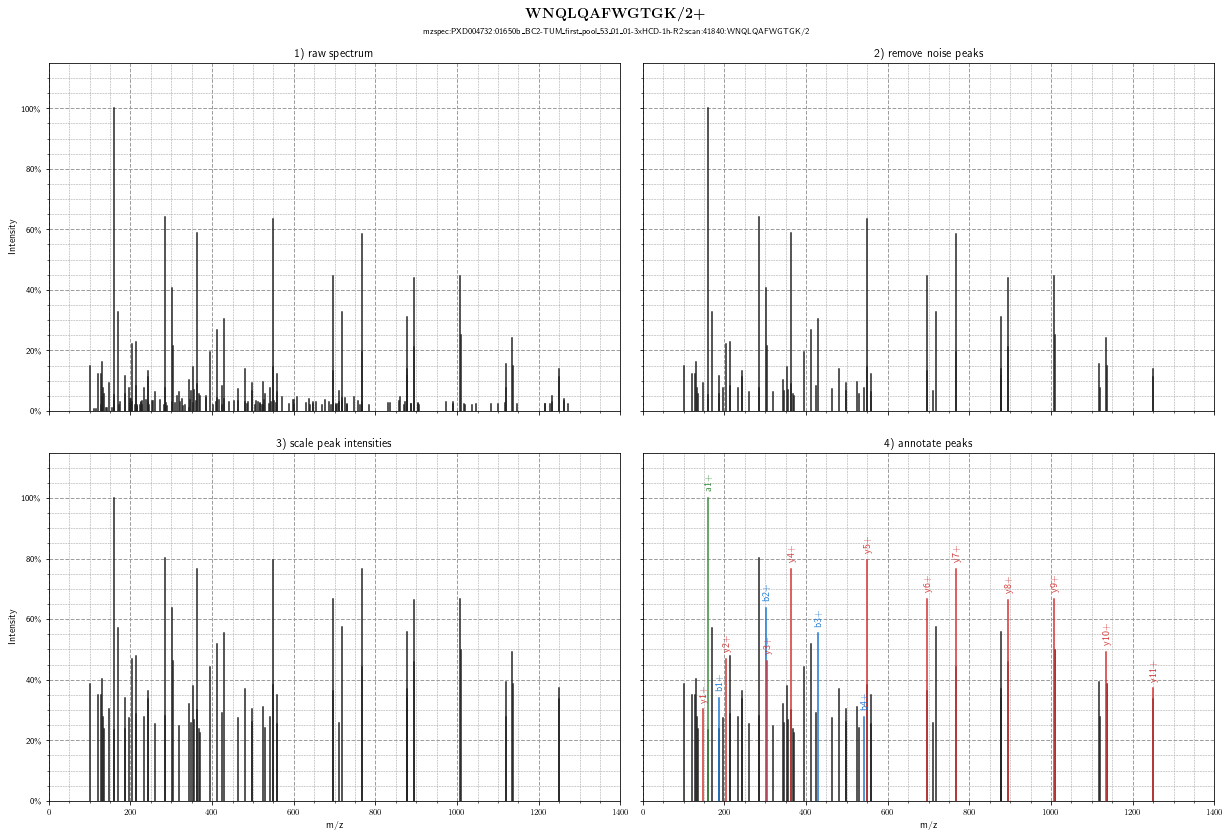

In [6]:
fig, axes = plt.subplots(2, 2, True, True, figsize=(18, 12))

# Panel 1: Raw spectrum.
spec = spec.set_mz_range(min_mz, max_mz)

plot.spectrum(spec, ax=axes[0, 0])

axes[0, 0].set_title('1) raw spectrum')
axes[0, 0].xaxis.label.set_visible(False)

# Panel 2: Remove noise peaks.
spec = (spec.remove_precursor_peak(fragment_tol_mass, fragment_tol_mode)
        .filter_intensity(min_intensity, max_num_peaks))

plot.spectrum(spec, ax=axes[0, 1])

axes[0, 1].set_title('2) remove noise peaks')

axes[0, 1].xaxis.label.set_visible(False)
axes[0, 1].yaxis.label.set_visible(False)

# Panel 3: Scale peak intensities.
spec = spec.scale_intensity(scaling)

plot.spectrum(spec, ax=axes[1, 0])

axes[1, 0].set_title('3) scale peak intensities')

# Panel 4: Annotation fragment peaks.
spec = spec.annotate_peaks(fragment_tol_mass, fragment_tol_mode, ion_types)

plot.spectrum(spec, ax=axes[1, 1])

axes[1, 1].set_title('4) annotate peaks')

axes[1, 1].yaxis.label.set_visible(False)

fig.suptitle(f'{{\\Large \\bf {spec.peptide}/{spec.precursor_charge}}}\n'
             f'{{\\footnotesize {spec.identifier}}}'.replace('_', '\_'),
             y=1)

plt.tight_layout(pad=4, w_pad=1, h_pad=2)

plt.show()
plt.close()

## Modifications

Peak annotation is based on the peptide sequence associated with the MS/MS spectrum.

`spectrum_utils` is able to annotate **modified peptides** by specifying the amino acid index and corresponding mass difference for each modification.

Modification positions can be the following:

- The index of the amino acid where the modification is present (0-based).
- 'N-term' for N-terminal modifications.
- 'C-term' for C-terminal modifications.

Mass differences can be positive or negative.

In [7]:
peptide = 'DLTDYLMK'
modifications = {6: 15.994915}

In [8]:
spectra = []
for mgf_spectrum in mgf.read('spectra.mgf'):
    if peptide in mgf_spectrum['params']['title']:
        spectra.append(spectrum.MsmsSpectrum(
            mgf_spectrum['params']['title'],
            mgf_spectrum['params']['pepmass'][0],
            mgf_spectrum['params']['charge'][0],
            mgf_spectrum['m/z array'],
            mgf_spectrum['intensity array'],
            retention_time=float(mgf_spectrum['params']['rtinseconds']),
            peptide=peptide,
            modifications=modifications))

In [9]:
fragment_tol_mass, fragment_tol_mode = 0.5, 'Da'
min_intensity, max_num_peaks = 0.01, 50

In [10]:
for spec in spectra:
    (spec.set_mz_range(min_mz, max_mz)
         .remove_precursor_peak(fragment_tol_mass, fragment_tol_mode)
         .filter_intensity(min_intensity, max_num_peaks)
         .scale_intensity(scaling)
         .annotate_peaks(fragment_tol_mass, fragment_tol_mode, ion_types))

A **mirror plot** can be used to easily visualize the correspondence between two MS/MS spectra.

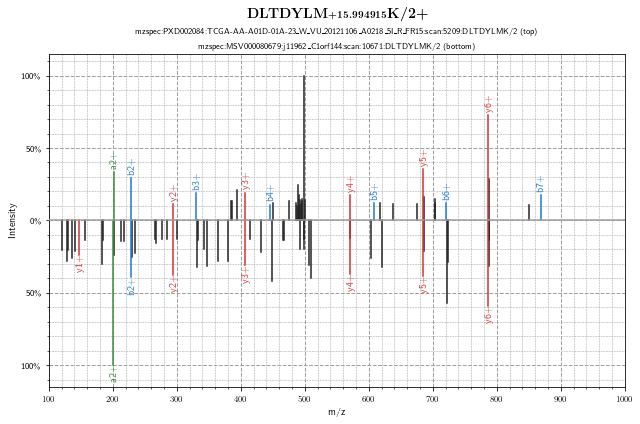

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))

plot.mirror(*spectra, ax=ax)

peptide_title = list(peptide)
for mod_pos, mod_md in modifications.items():
    if mod_pos not in ('N-term', 'C-term'):
        peptide_title[mod_pos] =\
            f'{peptide_title[mod_pos]}{{\\normalsize {mod_md:+f}}}'
for mod_pos, mod_md in modifications.items():
    if mod_pos == 'N-term':
        peptide_title.insert(0, f'{{\\normalsize {mod_md:+f}}}-')
    elif mod_pos == 'C-term':
        peptide_title.insert(len(peptide_title),
                             f'-{{\\normalsize {mod_md:+f}}}')
peptide_title = ''.join(peptide_title)
title = '\n'.join([
    f'{{\\Large \\bf {peptide_title}/{spectra[0].precursor_charge}}}',
    f'{{\\footnotesize {spectra[0].identifier} (top)}}',
    f'{{\\footnotesize {spectra[1].identifier} (bottom)}}']).replace('_', '\_')
ax.set_title(title)

# Make the percentage axis work with LaTeX.
ax.yaxis.set_major_formatter(mticker.FuncFormatter(
        lambda x, pos: f'{abs(x):.0%}'.replace('%', r'\%')))

plt.tight_layout()

plt.show()
plt.close()

## Interactive plotting

Besides the standard [Matplotlib](https://matplotlib.org/)-based plotting functionality, `spectrum_utils` can also produce **interactive plots**, e.g. for use in Jupyter notebooks or web applications, using [Altair](https://altair-viz.github.io/).

Interactive plotting is available through `spectrum_utils.iplot`, which is more or less a drop-in replacement for `spectrum_utils.plot`.

Interactive plots are similar to static plots, but also include tooltips with detailed information on spectrum peaks, and can optionally be made zoomable.

In [12]:
import altair

from spectrum_utils import iplot


altair.renderers.enable('notebook')

RendererRegistry.enable('notebook')

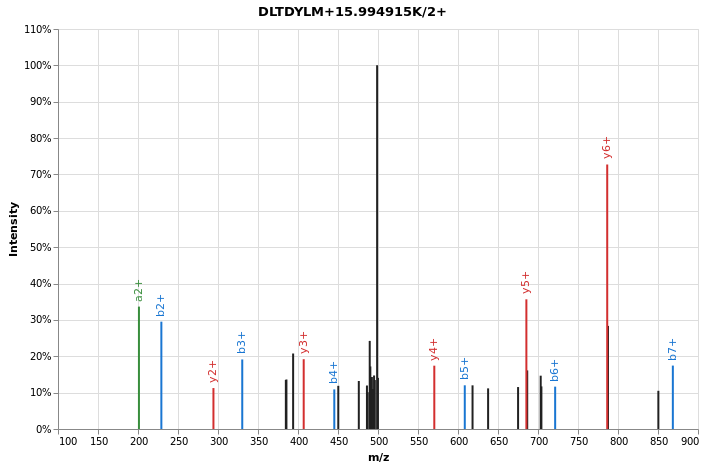

In [13]:
peptide_title = list(peptide)
for mod_pos, mod_md in modifications.items():
    if mod_pos not in ('N-term', 'C-term'):
        peptide_title[mod_pos] = f'{peptide_title[mod_pos]}{mod_md:+f}'
for mod_pos, mod_md in modifications.items():
    if mod_pos == 'N-term':
        peptide_title.insert(0, f'{mod_md:+f}-')
    elif mod_pos == 'C-term':
        peptide_title.insert(len(peptide_title), f'-{mod_md:+f}')
peptide_title = ''.join(peptide_title)

iplot.spectrum(spectra[0]).properties(
    title=f'{peptide_title}/{spectra[0].precursor_charge}',
    width=640, height=400)

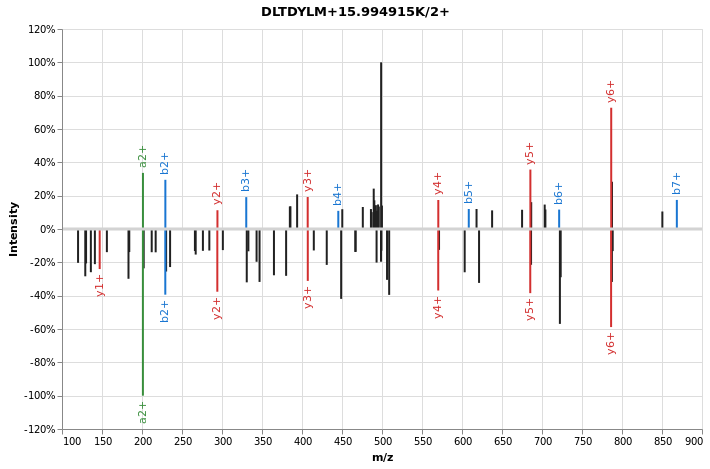

In [14]:
iplot.mirror(*spectra).properties(
    title=f'{peptide_title}/{spectra[0].precursor_charge}',
    width=640, height=400)